In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
cd /raid/home/myang349/recsys-filterbubbles/

/raid/home/myang349/recsys-filterbubbles


# Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities, shannon_index, gini_simpson_index, num_unique
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions
from dataclasses import dataclass
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import seaborn as sns
sns.set(style='darkgrid')

# Loading Data

In [12]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = "104k"
SAVE_FOLDER = "/raid/home/myang349/recsys-filterbubbles/data/twitch_sequence/"
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [13]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Loading model

In [14]:
# model = train_model()

# Init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
model = LSTM(input_size=128, output_size=3312, hidden_dim=64, n_layers=1, device=device) 
model.LSTM.flatten_parameters()
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

# Loading
model, _, epoch, loss = load_tracin_checkpoint(model, optimizer, "/raid/home/myang349/recsys-filterbubbles/checkpoints/lstm_checkpoint_epoch600.pt")

Device is cuda


In [15]:
model.to(device)

LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

## Verify the recall

In [16]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [17]:
# Generate predictions
predictions = get_topk_predictions(model, sequences, k=50)

In [18]:
assert len(sequences) == len(predictions)
hit = 0
total = 0
for i, val in enumerate(gt):
    if val in predictions[i][:10]:
        hit += 1
    total += 1  
# should be around .505
hit/total

0.5059769615301022

# Analysis Utils

In [19]:
def plot_counts(counts: dict[str, int], title='bla', xlabel='something', ylabel='count') -> plt.Figure:
    """Plots a histogram from dict"""
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#     return fig

def line_plot(hm):
    # line plot
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

## Computing community vectors

In [20]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

## Converting prev and predictions to be equal length and in community embedding

In [21]:
LOOKBACK = 50
THRESHOLD = 0

In [22]:
# Alternate version where we just get the last lookback from prev
prev_comm = []
pred_comm = []

for i in range(len(sequences)):
    prev = list(reversed(sequences[i]))[:LOOKBACK]
    n = len([x for x in prev if x != 0 and x in community_dict])
    
    if n < THRESHOLD:
        continue
        
    pred = predictions[i][:n]
    prev_comm.append(get_communities(prev, community_dict))
    pred_comm.append(get_communities(pred, community_dict))
    
for i in range(len(prev_comm)):
    assert len(prev_comm[i]) ==len(pred_comm[i])
    assert THRESHOLD <= len(prev_comm[i]) <= LOOKBACK
    
print(len(sequences))
print(len(prev_comm))

9202
9202


# Analysis

In [23]:
community_counts = Counter(community_dict.values())

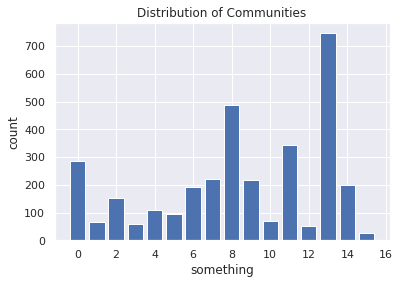

In [24]:
plot_counts(community_counts, 'Distribution of Communities')

In [25]:
## Community Items
hm = defaultdict(int)
for pt in train_data:
    seq = pt[0]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)

defaultdict(<class 'int'>, {13: 331189, 8: 253046, 9: 63591, 2: 41070, 14: 57209, 7: 108220, 6: 66264, 4: 71707, 11: 109750, 3: 28239, 0: 266909, 10: 21840, 1: 11578, 15: 3630, 5: 27141, 12: 8982})


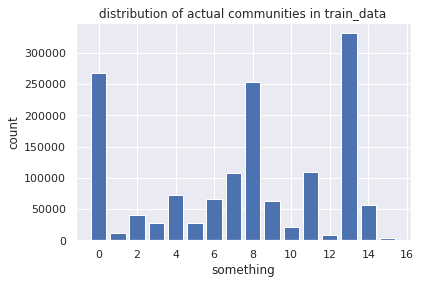

In [26]:
plot_counts(hm, 'distribution of actual communities in train_data')

defaultdict(<class 'int'>, {13: 71993, 8: 57095, 9: 14307, 6: 15960, 4: 15467, 2: 9093, 11: 24827, 7: 24195, 3: 6268, 0: 60679, 14: 13008, 10: 4593, 1: 2790, 15: 877, 5: 6232, 12: 2205})


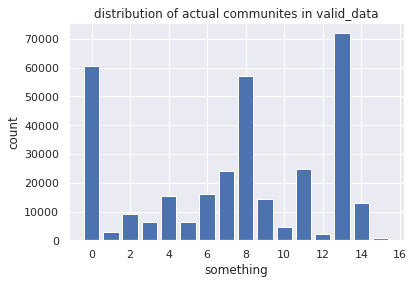

In [27]:
## Community Items
hm = defaultdict(int)
for pt in valid_data:
    seq = pt[0]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)
plot_counts(hm, 'distribution of actual communites in valid_data')

defaultdict(<class 'int'>, {8: 1540, 2: 291, 10: 116, 9: 394, 6: 477, 13: 1888, 0: 1736, 11: 693, 1: 83, 7: 722, 4: 440, 15: 29, 5: 179, 14: 375, 3: 167, 12: 72})


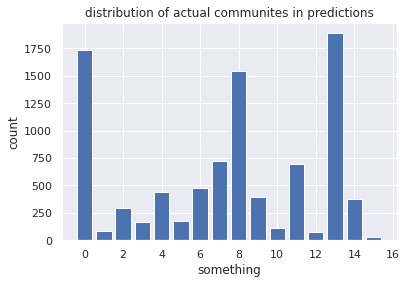

In [28]:
## Community Items
hm = defaultdict(int)
for seq in predictions:
    seq = seq[:1]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)
plot_counts(hm, 'distribution of actual communites in predictions')

## Distributions

In [36]:
n = len(prev_comm)
watch_history_length_counts = Counter(len(x) for x in prev_comm)
counts = {k: watch_history_length_counts[k] for k in sorted(watch_history_length_counts)}
assert sum(counts.values()) == n

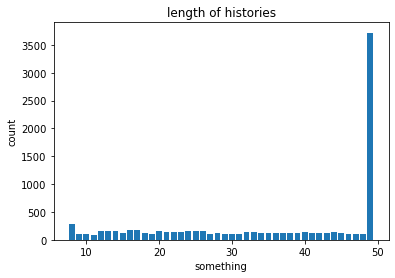

In [37]:
plot_counts(counts, 'length of histories')

In [29]:
prev_unique_comms_by_length = defaultdict(list)
pred_unique_comms_by_length = defaultdict(list)

In [30]:
# Making sure distribution is the same
assert Counter(len(x) for x in pred_comm) == Counter(len(x) for x in prev_comm)

### Plotting Recall @ 10 by length of training data

In [31]:
gt = [pt[1] for pt in valid_data]

In [32]:
assert len(gt) == len(prev_comm)

In [39]:
hm = defaultdict(list)
for i in range(len(prev_comm)):
    curr_len = len(prev_comm[i])
    label = gt[i]
    if label in predictions[i][:10]:
        hm[curr_len].append(1)
    else:
        hm[curr_len].append(0)
for k, v in hm.items():
    hm[k] = sum(v) / len(v)

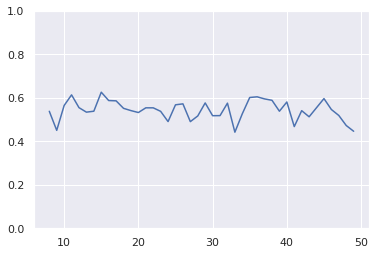

In [40]:
# line plot
fig = plt.figure()
ax = plt.axes()
ax.set_ylim(ymin=0)
ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

### Plotting relative diversity of data points by length

In [125]:
diversity_metric = num_unique
# diversity_metric = gini_simpson_index

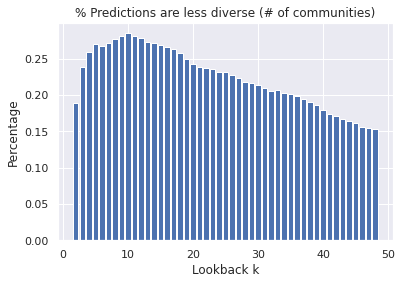

In [128]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) > diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)

for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, '% Predictions are less diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

hm_pred_is_less_diverse = hm

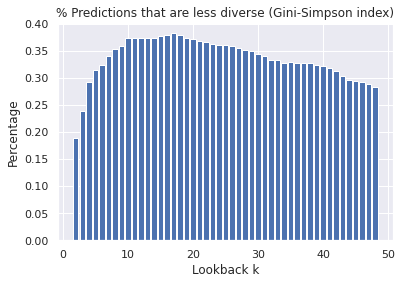

In [73]:
plot_counts(hm_pred_is_less_diverse, '% Predictions that are less diverse (Gini-Simpson index)', xlabel='Lookback k', ylabel='Percentage')
            
            

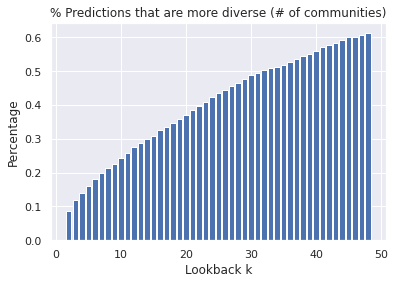

In [85]:
plot_counts(hm_pred_is_more_diverse, '% Predictions that are more diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

## Line plot

Text(0, 0.5, 'Percentage')

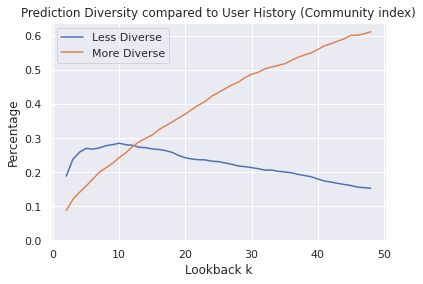

In [87]:
# Line plot
x, y = list(hm_pred_is_less_diverse.keys()), list(hm_pred_is_less_diverse.values())
x2,y2 = list(hm_pred_is_more_diverse.keys()), list(hm_pred_is_more_diverse.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [hm_pred_is_less_diverse[i] for i in sorted(x)], label='Less Diverse')
ax.plot(sorted(x2), [hm_pred_is_more_diverse[i] for i in sorted(x2)], label='More Diverse')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Prediction Diversity compared to User History (Community index)")
plt.xlabel("Lookback k")
plt.ylabel("Percentage")

(0.0, 0.39215871071937136)

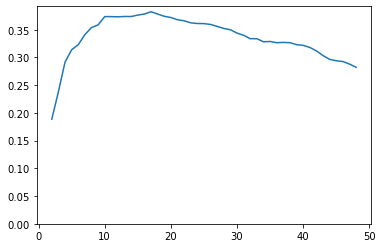

In [141]:
x, y = list(hm.keys()), list(hm.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [hm[i] for i in sorted(x)])
ax.set_ylim(ymin=0)

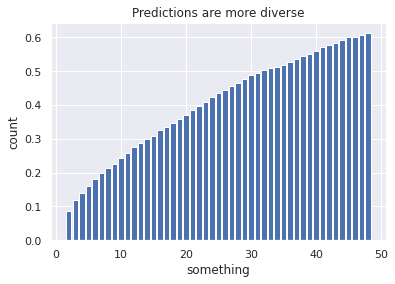

In [84]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) < diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)
for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, 'Predictions are more diverse')

hm_pred_is_more_diverse = hm

(0.0, 0.6388703455069376)

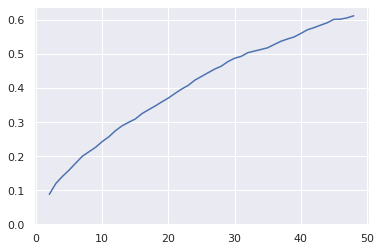

In [52]:
x, y = list(hm.keys()), list(hm.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [hm[i] for i in sorted(x)])
ax.set_ylim(ymin=0)

In [147]:
df = pd.DataFrame({'length': hm_pred_is_less_diverse.keys(), 'count': hm_pred_is_less_diverse.values()})

In [150]:
sns.set(style='darkgrid')

<AxesSubplot:xlabel='length', ylabel='count'>

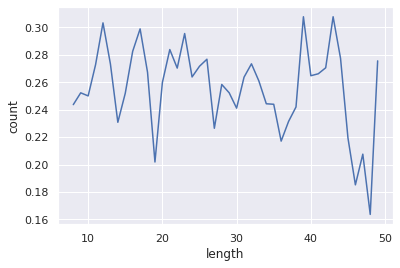

In [151]:
sns.lineplot(x='length', y='count', data=df)

# Seaborn bar plots

In [145]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) == diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)
for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])

plot_counts(hm, 'Equally Diverse')

hm_pred_is_equally_diverse = hm

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


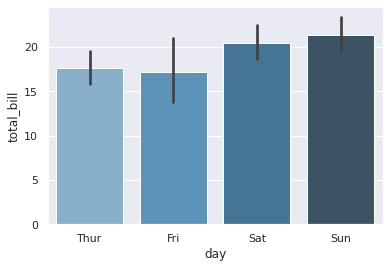

In [155]:
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips,palette="Blues_d")

## Raw Diversity

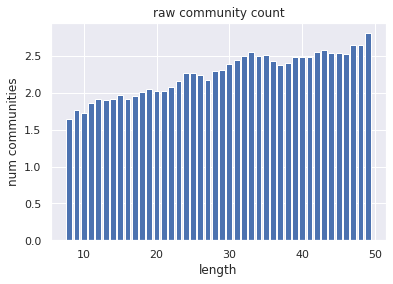

In [ ]:
# prev_communities only
hm1 = defaultdict(list)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm1[len(c1)].append(len(set(c1)))

    
# Convert to percents
for k in hm1:
    hm1[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count', xlabel='length', ylabel='num communities')

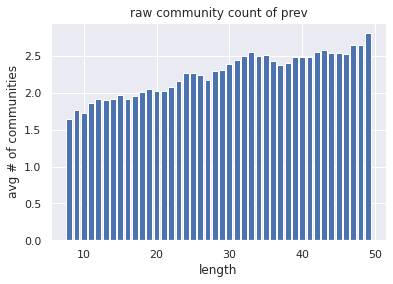

In [88]:
# pred_communities only
hm2 = defaultdict(list)
for i in range(len(pred_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm2[len(c2)].append(len(set(c2)))
    
# Convert to percents
for k in hm2:
    hm2[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count of prev', xlabel='length', ylabel='avg # of communities')

In [92]:
hs = set()
for seq in prev_comm:
    for x in seq:
        hs.add(x)

In [93]:
hs

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [ ]:
hm

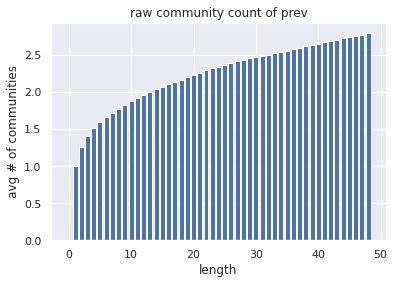

In [100]:
# full prev communities
hm = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    for j in range(len(c1)):
#         hm[j].append(len(set(c1[:j])))
        hm[j].append(diversity_metric()], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
plot_counts(hm, 'raw community count of prev', xlabel='length', ylabel='avg # of communities')
prev_communities = hm

## Using Gini-Simpson Index

In [116]:
# full prev communities
hm = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    for j in range(1, len(c1)):
        hm[j].append(diversity_metric(c1[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
prev_communities = hm

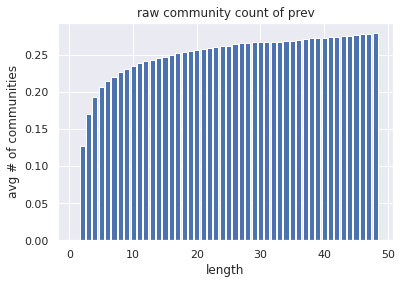

In [118]:
plot_counts(prev_communities, 'raw community count of prev', xlabel='length', ylabel='avg # of communities')

In [120]:
# full pred communities
hm = defaultdict(list)
for pred in predictions:
    c2 = get_communities(pred, community_dict)
    for j in range(1, len(pred)):
#         hm[i].append(len(set(c2[:i])))
        hm[j].append(diversity_metric(c2[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
pred_communities = hm

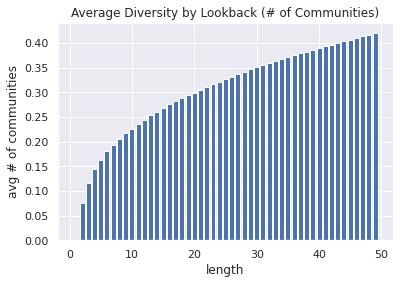

In [121]:
plot_counts(pred_communities, 'Average Diversity by Lookback (# of Communities)', xlabel='length', ylabel='avg # of communities')

Text(0, 0.5, 'Gini-Simpson Diversity Score')

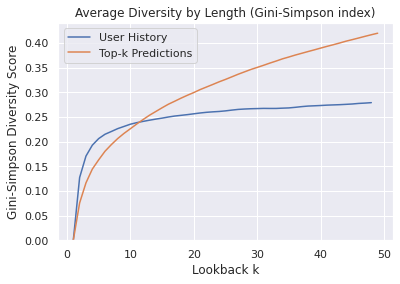

In [124]:
# Line plot
x, y = list(prev_communities.keys()), list(prev_communities.values())
x2,y2 = list(pred_communities.keys()), list(pred_communities.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [prev_communities[i] for i in sorted(x)], label='User History')
ax.plot(sorted(x2), [pred_communities[i] for i in sorted(x2)], label='Top-k Predictions')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Average Diversity by Length (Gini-Simpson index)")
plt.xlabel("Lookback k")
plt.ylabel("Gini-Simpson Diversity Score")

Text(0, 0.5, 'Average # of Communities')

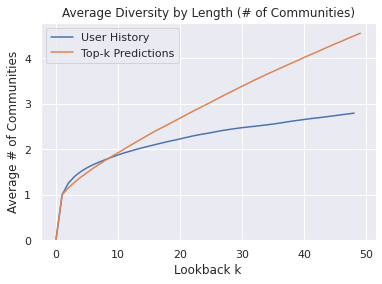

In [104]:
# Line plot
x, y = list(prev_communities.keys()), list(prev_communities.values())
x2,y2 = list(pred_communities.keys()), list(pred_communities.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [prev_communities[i] for i in sorted(x)], label='User History')
ax.plot(sorted(x2), [pred_communities[i] for i in sorted(x2)], label='Top-k Predictions')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Average Diversity by Length (# of Communities)")
plt.xlabel("Lookback k")
plt.ylabel("Average # of Communities")

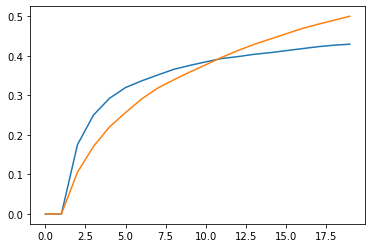

In [284]:
# last k for every train, topk for pred
hm_prev = defaultdict(list)
hm_pred = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    c2 = get_communities(predictions[i], community_dict)
    for j in range(min(len(c1), 20)):
#         hm_prev[j].append(len(set(c1[:j])))
#         hm_pred[j].append(len(set(c2[:j])))
        hm_prev[j].append(shannon_index(list(reversed(c1))[:j], community_dict))
        hm_pred[j].append(shannon_index(c2[:j], community_dict))
        
for k in hm_prev:
    hm_prev[k] = np.mean(hm_prev[k])
for k in hm_pred:
    hm_pred[k] = np.mean(hm_pred[k])

fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(hm_prev.keys()), [hm_prev[x] for x in sorted(hm_prev.keys())])
ax.plot(sorted(hm_pred.keys()), [hm_pred[x] for x in sorted(hm_pred.keys())])

## Quantifying Diversity Based on Watch History vs Recommendation

In [194]:
def f(c):
    return len(set(c))
    
def f(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.8 * len(c):
            return 1
    return 0

In [202]:
prev_comm_stats = []
pred_comm_stats = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
    if len(c1) < threshold:
        continue
    prev_comm_stats.append(f(c1))
    pred_comm_stats.append(f(c2))

In [203]:
sum(prev_comm_stats)

5793

In [204]:
sum(pred_comm_stats)

4230

# Quantifying Filter-Bubble Based on Combination of Watch History + Recommendation

## Quantify Functions

In [232]:
# Does one of the top 3 predictions belong in a community in the previous history?
def f(prev, pred, threshold=3):
    for comm in pred[:threshold]:
        if comm in prev:
            return 1
    return 0

# Does one of the top-threshold belong in the majority community in the previous history?
def f(prev, pred, threshold=3):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    for comm in pred[:threshold]:
        if comm == most_common:
            return 1
    return 0

# What % of the top-threshold belongs in the most common community in the previous history
def f(prev, pred, threshold=3):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    count = 0
    for comm in pred[:threshold]:
        if comm == most_common:
            count += 1
    return count / threshold

In [221]:
# What percentage of the top-threshold predictions belong in a community in the previous history?
def f(prev, pred, threshold=5):
    count = 0
    for comm in pred[:threshold]:
        if comm in prev:
            count += 1
    return count / threshold

# What percentage of the top-threshold predictions belong in the communities of the last threshold-items in the history?
def f(prev, pred, threshold=10):
    count = 0
    for comm in pred[:threshold]:
#         if comm in list(reversed(prev))[:threshold]:
        if comm in prev[-threshold:]:
            count += 1
    return count / threshold

## Filter functions

In [222]:
def filter(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.9 * len(c):
            return True
    return False

## This cell actually computes values

In [233]:
counts = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if not filter(c1):
#         continue
    if len(c1) < threshold:
        continue
    counts.append(f(c1,c2))

In [234]:
sum(counts)/len(counts)

0.859450844019424

In [235]:
sum(counts)/len(counts)

0.859450844019424

# Classifying training data by filter bubble and non-filter bubble

## Comparing how often there is a filter bubble

In [319]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [329]:
len(prev_comm)

9202

In [343]:
sum(1 if get_communities(sequences[i], community_dict) == community_dict[gt[i] else 0 for i in range(len(gt)))

SyntaxError: invalid syntax (923868302.py, line 1)

In [ ]:
sequences[0]

In [410]:
# def filter(c):
# #     last_10 = sequence[-10:]
#     for val in Counter(c).values():
#         if val >= 0.9 * len(c):
#             return 1
#     return 0

def is_filter_bubble(c, label):
#     last_10 = sequence[-10:]
#     c = c[-10:]
    for key, val in Counter(c).items():
        if val >= 0.90 * len(c) and key == community_dict[label]:
#         if val >= 0.9 * len(c):
            return 1
    return 0

nums = []
for i, sequence in enumerate(prev_comm):
#     nums.append(is_filter_bubble(sequence, gt[i]))
    nums.append(is_filter_bubble(sequence, predictions[i][0]))

In [379]:
sum(nums) / len(nums)

0.549771788741578

In [363]:
len(nums)

9202

In [365]:
sum(nums) / len(nums)

0.549771788741578

In [443]:
ls

backup_checkpoint/        LICENSE               preprocess_for_lstm.py
checkpoints/              LSTM_clean/           __pycache__/
checkpoints_v2/           LSTM_Sejoon/          README.md
data/                     lstm_wrapper.py       tracin/
depr/                     myang_code_refactor/
diversity_experiments.py  myang_tracin_lstm.py


In [453]:
with open("length_influences_dict.pkl", 'rb') as f:
    influences = pickle.load(f)

In [454]:
for k, v in influences.items():
    influences[k] = sum(abs(x) for x in influences[k])

In [456]:
influences

{0: 0.19615576608339325,
 2: 0.13059878681087866,
 4: 0.08724804024677724,
 6: 0.06313548100297339,
 8: 0.057922716689063236,
 10: 0.07100643284502439,
 12: 0.089271603646921,
 14: 0.08094245778920595,
 16: 0.09046301498892717,
 18: 0.06926983622906846,
 20: 0.09784355520969257,
 22: 0.09645548567641526,
 24: 0.14919478580122814,
 26: 0.12303912942297757,
 28: 0.12479540366621222,
 30: 0.1039797104022,
 32: 0.12097836847533472,
 34: 0.1563789519132115,
 36: 0.14293774054385722,
 38: 0.22456581727601588,
 40: 0.18615880492143333,
 42: 0.17048273367981892,
 44: 0.22241657506674528,
 46: 0.20862414606381208,
 48: 0.2033533367648488}

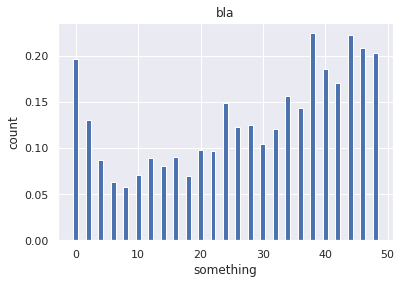

In [455]:
plot_counts(influences)

## Comparing how often GT is in previous communities vs the top ith prediction

In [434]:
def is_filter_bubble(c, label):
#     last_10 = sequence[-10:]
#     c = c[-10:]
    for key, val in Counter(c).items():
        if val >= 0.9 * len(c) and key == community_dict[label]:
#         if val >= 0.9 * len(c):
            return 1
    return 0

In [435]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [436]:
nums1 = []
nums2 = []
for i in range(len(sequences)):
#     if community_dict[gt[i]] in get_communities(sequences[i][-10:], community_dict):
    if is_filter_bubble(get_communities(sequences[i], community_dict), gt[i]):
        nums1.append(1)
    else:
        nums1.append(0)
        
#     if community_dict[predictions[i][10]] in get_communities(sequences[i][-10:], community_dict):
    if is_filter_bubble(get_communities(sequences[i], community_dict), predictions[i][0]):
        nums2.append(1)
    else:
        nums2.append(0)

In [437]:
sum(nums1) / len(nums1)

0.4407737448380787

In [438]:
sum(nums2)/ len(nums2)

0.45544446859378396

In [439]:
sum(nums1) / len(nums1)

0.4407737448380787

In [440]:
sum(nums2)/ len(nums2)

0.45544446859378396

## Extracting filter bubble pts + breaking the filter bubble pts

In [237]:
DIVERSITY_FOLDER = os.path.join(SAVE_FOLDER, "twitch_sequence")

In [67]:
pwd

'/raid/home/myang349/recsys-filterbubbles'

In [457]:
with open('/raid/home/myang349/recsys-filterbubbles/myang_code_refactor/final_analysis/length_influences1_dict.pkl', 'rb') as f:
    
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/raid/home/myang349/recsys-filterbubbles/myang_code_refactor/final_analysis/length_influences1_dict.pkl'

In [70]:
hm = {}
for key in data:
    hm[key] = sum(data[key])

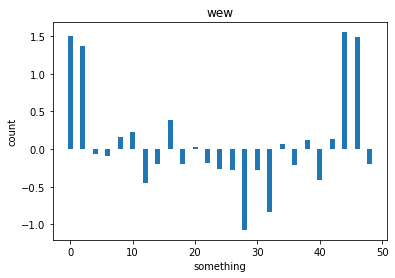

In [72]:
plot_counts(hm, 'wew')

In [460]:
len(train_data[0])

2